In [1]:
### Import Libaries
### Modules needed for NLP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import json
import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx
import warnings
from textblob import TextBlob
#Google modules
import httplib2
from apiclient import discovery
from google.oauth2 import service_account
import pygsheets

# from apscheduler.schedulers.blocking import BlockingScheduler

# def some_job():
#     print("Hourly sheet update")

# scheduler = BlockingScheduler()
# scheduler.add_job(some_job, 'interval', hours=1)
# scheduler.start()

warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
#Authorize API's
#Authorize Twitter API
f = open('/home/pi/twitter_api_creds.json')
creds = json.load(f)
consumer_key = creds['consumer_key']
consumer_secret = creds['consumer_secret']
access_token = creds['access_token']
access_token_secret = creds['access_token_secret']
f.close()

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)
#Authorize Google's API
scopes = ["https://www.googleapis.com/auth/drive", "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/spreadsheets"]
secret_file = '/home/pi/client_secret.json'
gc = pygsheets.authorize(service_file='/home/pi/client_secret.json')


credentials = service_account.Credentials.from_service_account_file(secret_file, scopes=scopes)
service = discovery.build('sheets', 'v4', credentials=credentials)

In [3]:
#Twitter Functions
#Calls on clean() for text cleanup then removes the URL
def remove_url(txt):
    #Call on clean to clean text first
    txt = clean(txt)
    #removes URL
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

#Cleans up the text like newlines before url is removed.
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

In [4]:
#Twitter functions
#Returns DF of list of cleaned tweets for sentiment analysis
#Calls on clean_url() in above block to clean and remove URL
#Takes in user inputs as parameters to search for tweets
#Can also be used alone if the terms are hardcoded; for testing
def extract_tweets_configed(search_term, opt, num, date_ans):
    tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since=date_ans).items(num)
    # Remove URLs by calling on functions in block above
    tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]
    # Create textblob objects of the tweets
    sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]
    # Get sentiment values
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    #put into dataframe
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
    #remove neutral sentiment values
    #sentiment_df = sentiment_df[sentiment_df.polarity != 0]
    return sentiment_df
#Gets the user inputs to pass to extract_tweets_configed
#Prompts for search term, retweet filter option, num to extract and date since.
def user_inputs():
    # Valid final string ex. "#climate+change -filter:retweets"
    print("Enter tweet search term(s): ")
    print("E.g. ''#climatechange' should be entered as: #climate+change")
    search_term = input()
    #Prompt for retweet filter
    opt = input("Filter out retweets? Enter as y/n: ")
    if (opt == 'y'):
        search_term = search_term + " -filter:retweets"
    #prompt for number of tweets to be extracted    
    num = input("How many tweets to be extracted? Enter as int: ")
    num = int(num)
    #prompt for date since in YYYY-MM-DD or default to '2018-11-01'
    date = '2018-11-01'
    date_ans = input("Since what date? Enter as: YYYY-MM-DD or 'n' for default of 2018-11-01: ")
    if (date_ans == 'n'):
        date_ans = date
    df = extract_tweets_configed(search_term, opt, num, date_ans)
    return df
#Calls on user_inputs and returns a cleaned dataframe of tweets ready for sentiment analysis.
def extract_tweets():
    return user_inputs()

In [7]:
# df = extract_tweets()
search_term = "#climate+change -filter:retweets"
opt = "y"
num = 1000
date = '2018-11-01'

df = extract_tweets_configed(search_term, opt, num, date)
df = df[df.polarity != 0]
# df.head()

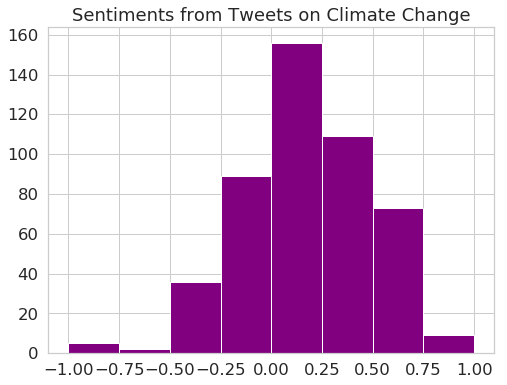

In [8]:
# #Here for what expected graph should look like in google sheets
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")


plt.title("Sentiments from Tweets on Climate Change")
plt.show()

In [9]:
# spreadsheet_id = '1YLnWNTjsHNhGe65tKdrU_8VRqsAVQmPy4hbqYWpWltw'
sh = gc.open('NLP Sentiment dashboard')
wks = sh[0]
#So graph in next columns/some data is maintained.
wks.clear(end='B')

# cell_form = cell('A1')
# cell_form = (0,0,0,0)
wks.set_dataframe(df,(1,1))